#MSW Episode Localizer

This Colab explores the fictional locations of the 284 episodes *Murder, She Wrote* in two different fashions:

*   The Long Way: web scraping > NLP (NER on raw text) > visualization
*   The Short Way: web scraping > NLP (NER on tags) > visualization

by @LucaGiovannini


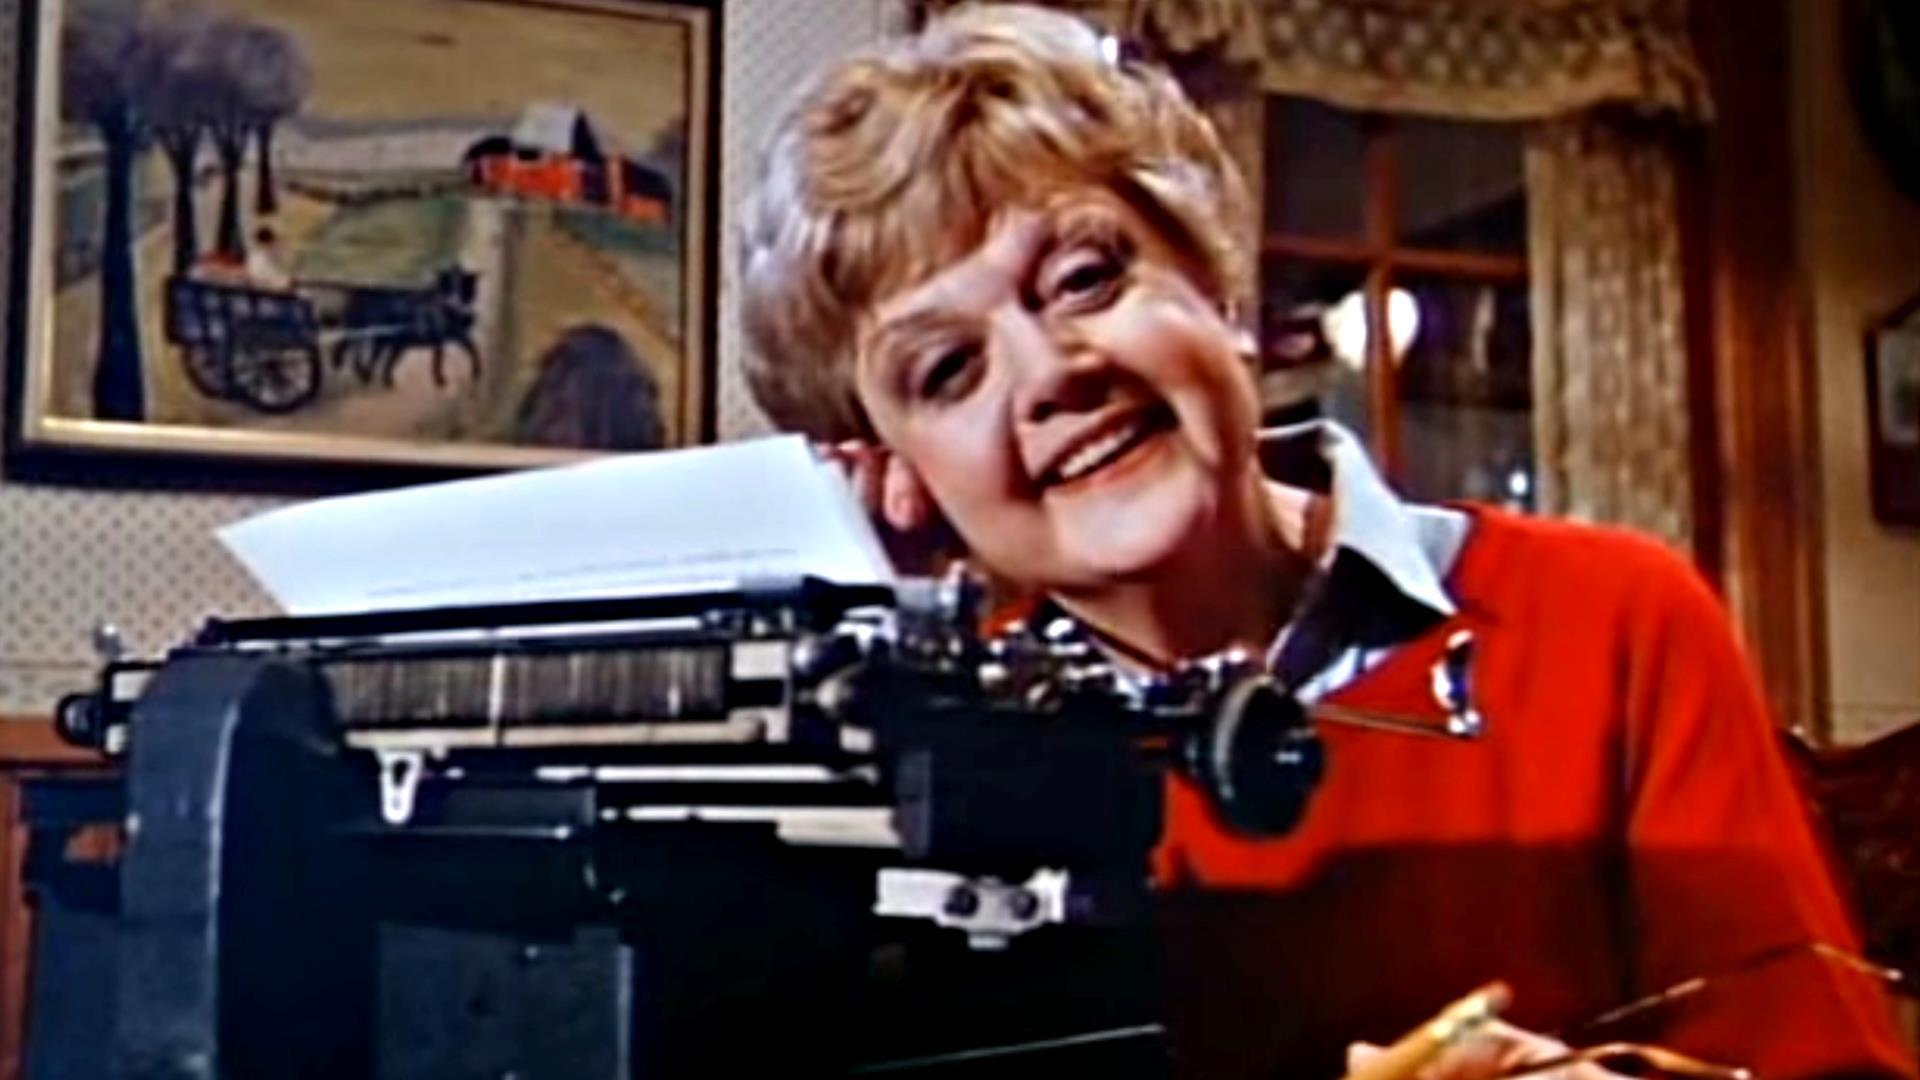

# 1. The Long Way

*   Scraping a blog which contains the plot summaries for each episode of MSW using ***BeautifulSoup***
*   Cleaning raw text with ***re*** and creating a list entry for each episode
*   Performing NER (Named Entity Recognition) with ***SpaCy*** on the text chunks in order to find where every episode is set
*   Plotting the results on a real-world map with ***geopy*** and ***basemap***

In [1]:
# all imports (except for plotting libraries)
import requests
from bs4 import BeautifulSoup
import re
import string
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
import spacy
spacy_nlp = spacy.load('en_core_web_sm') 
import numpy
!pip install geopy
from geopy.geocoders import Nominatim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Scraping and cleaning

In [2]:
# define a text cleaning function

def remove_unwanted_text(text):
  
  stoplist = set(stopwords.words("english"))

  new_text = str(text)  
  new_text = re.sub('http\S+', '', new_text) # remove websites
  new_text = re.sub('\n\t', '', new_text) # solve some issues
  new_text = re.sub('JB', 'Jessica', new_text) # solve some issues
  new_text = "".join([char for char in new_text if char not in diacritics]) # remove diacritics
  new_text = re.sub('>np>', ' ', new_text) # we use this to isolate 'classpostcontent' for later splitting
  new_text = re.sub('\np>', ' ', new_text) # we use this to isolate 'classpostcontent' for later splitting
  new_text = re.sub('>', '', new_text)

  new_text_as_list = new_text.split(" ") # ora è di nuovo una lista
  final_text = []

  for word in new_text_as_list:
    if word not in stoplist:
      final_text.append(word)

  return final_text

In [3]:
# build the scraping algorithm

ep_list = []
num_pag = 1 # total = 30
url = 'https://murdersheblogged1.wordpress.com'

for i in range(30):

    # take in the url
    page = requests.get(url)

    # Create a BeautifulSoup object
    soup = BeautifulSoup(page.text, 'html.parser')

    # Pull all text from the post-content div
    ep_description = soup.find_all(class_='post-content')

    # append to list
    ep_list.append(ep_description)

    # clean list using remove_unwanted_text
    ep_list = remove_unwanted_text(ep_list)

    # print progress    
    print('I just scraped ' + url)
    
    # move on with loop
    num_pag = num_pag + 1
    url = 'https://murdersheblogged1.wordpress.com/page/' + str(num_pag) + '/'

I just scraped https://murdersheblogged1.wordpress.com
I just scraped https://murdersheblogged1.wordpress.com/page/2/
I just scraped https://murdersheblogged1.wordpress.com/page/3/
I just scraped https://murdersheblogged1.wordpress.com/page/4/
I just scraped https://murdersheblogged1.wordpress.com/page/5/
I just scraped https://murdersheblogged1.wordpress.com/page/6/
I just scraped https://murdersheblogged1.wordpress.com/page/7/
I just scraped https://murdersheblogged1.wordpress.com/page/8/
I just scraped https://murdersheblogged1.wordpress.com/page/9/
I just scraped https://murdersheblogged1.wordpress.com/page/10/
I just scraped https://murdersheblogged1.wordpress.com/page/11/
I just scraped https://murdersheblogged1.wordpress.com/page/12/
I just scraped https://murdersheblogged1.wordpress.com/page/13/
I just scraped https://murdersheblogged1.wordpress.com/page/14/
I just scraped https://murdersheblogged1.wordpress.com/page/15/
I just scraped https://murdersheblogged1.wordpress.com/pa

In [4]:
# further cleaning, splitting according to 'classpostcontent'
test = str(ep_list) 
test = re.sub(r"\\", '', test)
ep_list = test.split('classpostcontent')

In [5]:
# keep only the first 150 chars (to improve NER reliability, since episode location is most often spelled out in the first sentence)

for i in range(len(ep_list)):
  ep_list[i] = ep_list[i][0:150]

In [7]:
# lines 1, 2 are not episode plots so...

del ep_list[0]
del ep_list[0]

In [8]:
ep_list

["', 'Mmm', 'Pointed', 'episode', 'title', 'pointedp', 'Back', 'San', 'Francisco', 'one', 'last', 'time', 'Fletcherfans', 'David', 'Ogden', 'Stiers', 'l",
 "', 'Welcome', 'Atlanta', 'Fletcherfans', 'home', 'BRI', 'Biological', 'Research', 'Institute', 'absolutely', 'Centre', 'Infectious', 'Diseases', 'woul",
 "', 'And', 'head', 'back', 'Cove', 'one', 'last', 'time', 'Fletcherfans', 'it’s', 'see', 'dude', 'called', 'Johnny', 'hanging', 'girl', 'called', 'Sher",
 "', 'Back', 'Cove', 'second', 'last', 'time', 'Fletcherfans', 'Jessica', 'elected', 'Commodore', 'fleet', 'local', 'sailing', 'competition', 'apparentl",
 "', 'Once', 'upon', 'time', 'mythical', 'faraway', 'land', 'called', 'Australiap', 'I', 'know', 'I', 'didn’t', 'believe', 'either', 'I', 'remembered', ",
 "', 'Back', 'Cove', 'Fletcher', 'fans', 'Jessica', 'suffering', 'yearly', 'bout', 'writer’s', 'block', 'Deputy', 'Andy', 'buying', 'house', 'local', 's",
 "', 'Jessica', 'Wyoming', 'bit', 'RampR', 'week', 'Fortunately', 'fri

In [9]:
# we need to count all episodes based in Cabot Cove, since Spacy wouldn't recognise it as GPE/LOC
# they should be 55/284

ep_in_Cove = []
cove_counter = 0

for i in range(len(ep_list)):
  if 'Cove' in ep_list[i] or 'Cabot' in ep_list[i]:
    ep_in_Cove.append(ep_list[i])
    cove_counter += 1
print(cove_counter)

45


### NER on scraped text

In [10]:
# perform NER

import spacy
spacy_nlp = spacy.load('en_core_web_sm') 

locations = []

for i in range(len(ep_list)):
  
  spam = [",","'"]
  ep_list[i] = "".join(char for char in ep_list[i] if char not in spam)

  doc = spacy_nlp(ep_list[i])
  
  for entity in doc.ents:
    if entity.label_ == 'GPE' or entity.label == 'LOC':
      locations.append(entity.text)

print(locations)

['San Francisco', 'Los Angeles', 'Maine', 'New York', 'Texas', 'Ireland', 'Boston', 'South Carolina', 'New Orleans', 'Buffalo New York', 'Richmond', 'San Francisco', 'Chicago', 'New York', 'Cairns', 'San Francisco Fletcherfans Jessica', 'London', 'West th Street', 'Boston', 'New York Fletcherfans', 'New York', 'America', 'America', 'Florida', 'San Francisco', 'Richmond', 'San Francisco', 'Las Vegaspndiv', 'New Orleans', 'New York', 'New York', 'Pennsylvania', 'Georgia', 'Richmond', 'Texas', 'San Francisco', 'San Franciscoxaprobably', 'Tasmania', 'New York City', 'Los Angeles Fletcherfans', 'Los Angeles', 'San Francisco', 'Arizona', 'Montana', 'Tasmania', 'California', 'Moscow', 'Australia', 'Ohio', 'India', 'New York', 'Paris', 'Tennessee', 'California', 'Denver', 'Hawaii', 'Vietnam', 'Washington', 'Arkansas', 'Kansas', 'Jessica Washington DC', 'Boston', 'Oklahoma', 'California', 'Vermont', 'US', 'Tasmania', 'San Francisco', 'MSW']


In [11]:
# NER misses some easy targets (e.g. 'Atlanta' in row 2). Let's try making
# the words within the lists comma-separated and then performin NER again...

for i in range(len(ep_list)):
  comma_sep = str(ep_list).split(" ")

for i in range(len(comma_sep)):
  
  doc = spacy_nlp(comma_sep[i])
  
  for entity in doc.ents:
    if entity.label_ == 'GPE' or entity.label == 'LOC':
      if entity.text not in locations:
        locations.append(entity.text)

print(locations) # finds the locations which were previously missed, but obviously misses all two-words city names (e.g. 'New York')

['San Francisco', 'Los Angeles', 'Maine', 'New York', 'Texas', 'Ireland', 'Boston', 'South Carolina', 'New Orleans', 'Buffalo New York', 'Richmond', 'San Francisco', 'Chicago', 'New York', 'Cairns', 'San Francisco Fletcherfans Jessica', 'London', 'West th Street', 'Boston', 'New York Fletcherfans', 'New York', 'America', 'America', 'Florida', 'San Francisco', 'Richmond', 'San Francisco', 'Las Vegaspndiv', 'New Orleans', 'New York', 'New York', 'Pennsylvania', 'Georgia', 'Richmond', 'Texas', 'San Francisco', 'San Franciscoxaprobably', 'Tasmania', 'New York City', 'Los Angeles Fletcherfans', 'Los Angeles', 'San Francisco', 'Arizona', 'Montana', 'Tasmania', 'California', 'Moscow', 'Australia', 'Ohio', 'India', 'New York', 'Paris', 'Tennessee', 'California', 'Denver', 'Hawaii', 'Vietnam', 'Washington', 'Arkansas', 'Kansas', 'Jessica Washington DC', 'Boston', 'Oklahoma', 'California', 'Vermont', 'US', 'Tasmania', 'San Francisco', 'MSW', 'Atlanta', 'Japan', 'Rome', 'Gila', 'Hollywood', 'Gamg

Tip: it seems to make sense rerunning the above cells more than once, since NER results may vary. The ***precision*** rate (= true positives/true positives+false positives) of the model is around 85%; in my tests the algorithm recognises from time to time between 75 and 89 entities.

In [12]:
# check the unique results
len(locations)
numpy.unique(locations)

array(['America', 'Arizona', 'Arkansas', 'Atlanta', 'Australia', 'Boston',
       'Buffalo New York', 'Cairns', 'California', 'Canada', 'Chicago',
       'Denver', 'Eaton', 'England', 'Florida', 'Gamgee', 'Georgia',
       'Gila', 'Hawaii', 'Hollywood', 'Idaho', 'India', 'Indiana',
       'Ireland', 'Japan', 'Jessica Washington DC', 'Kansas',
       'Las Vegaspndiv', 'London', 'Los Angeles',
       'Los Angeles Fletcherfans', 'MSW', 'Maine', 'Manhattan', 'Milan',
       'Montana', 'Moscow', 'New Orleans', 'New York', 'New York City',
       'New York Fletcherfans', 'Ohio', 'Oklahoma', 'Paris',
       'Pennsylvania', 'Richmond', 'Rome', 'San Francisco',
       'San Francisco Fletcherfans Jessica', 'San Franciscoxaprobably',
       'Seattle', 'South Carolina', 'Tasmania', 'Tennessee', 'Texas',
       'US', 'Vegaspndiv', 'Vermont', 'Vietnam', 'Washington',
       'West th Street', 'trib'], dtype='<U34')

In [13]:
# clean locations results
# requires some Bayesian knowledge (Jessica's never been in Vietnam) and checks with cell 24 & 28
# some places (like Gila Junction, S12E3) does not actually exist, but they can be retraced to existing places (Gila County, AZ)

spam = ['America', 'Eaton', 'Gamgee', 'MSW', 'US', 'Vietnam', 'trib']
for i, word in enumerate(locations):
    if word in spam:
      del locations[i]
    elif word == 'Jessica Washington DC' or word == 'Washington':
        locations[i] = 'Washington DC'  
    elif word == 'Gila':
        locations[i] = 'Gila County, AZ'
    elif word == 'San Francisco Fletcherfans Jessica' or word == 'San Franciscoxaprobably':
        locations[i] = 'San Francisco'
    elif word == 'Buffalo New York':
        locations[i] = 'Buffalo'
    elif word == 'Portland':
        locations[i] = 'Portland, Maine'
    elif word == 'West th Street' or word == 'Manhattan' or word == 'New York Fletcherfans' or word == 'New York City':
        locations[i] = 'New York'
    elif word == 'Las Vegaspndiv' or word == 'Vegaspndiv':
        locations[i] = 'Las Vegas'
    elif word == 'Los Angeles Fletcherfans' or word == 'Hollywood':
        locations[i] = 'Los Angeles'

In [14]:
locations

['San Francisco',
 'Los Angeles',
 'Maine',
 'New York',
 'Texas',
 'Ireland',
 'Boston',
 'South Carolina',
 'New Orleans',
 'Buffalo',
 'Richmond',
 'San Francisco',
 'Chicago',
 'New York',
 'Cairns',
 'San Francisco',
 'London',
 'New York',
 'Boston',
 'New York',
 'New York',
 'America',
 'Florida',
 'San Francisco',
 'Richmond',
 'San Francisco',
 'Las Vegas',
 'New Orleans',
 'New York',
 'New York',
 'Pennsylvania',
 'Georgia',
 'Richmond',
 'Texas',
 'San Francisco',
 'San Francisco',
 'Tasmania',
 'New York',
 'Los Angeles',
 'Los Angeles',
 'San Francisco',
 'Arizona',
 'Montana',
 'Tasmania',
 'California',
 'Moscow',
 'Australia',
 'Ohio',
 'India',
 'New York',
 'Paris',
 'Tennessee',
 'California',
 'Denver',
 'Hawaii',
 'Washington',
 'Arkansas',
 'Kansas',
 'Washington DC',
 'Boston',
 'Oklahoma',
 'California',
 'Vermont',
 'Tasmania',
 'San Francisco',
 'Atlanta',
 'Japan',
 'Rome',
 'Gila County, AZ',
 'Los Angeles',
 'Canada',
 'Milan',
 'Las Vegas',
 'New York',


In [15]:
# dictionary with places and frequencies

D = {}

for elem in locations:
  if elem not in D.keys():
    D[elem] = 1
  else:
    D[elem] += 1 

print(D)

{'San Francisco': 9, 'Los Angeles': 4, 'Maine': 1, 'New York': 10, 'Texas': 2, 'Ireland': 1, 'Boston': 3, 'South Carolina': 1, 'New Orleans': 2, 'Buffalo': 1, 'Richmond': 3, 'Chicago': 1, 'Cairns': 1, 'London': 1, 'America': 1, 'Florida': 1, 'Las Vegas': 2, 'Pennsylvania': 1, 'Georgia': 1, 'Tasmania': 3, 'Arizona': 1, 'Montana': 1, 'California': 3, 'Moscow': 1, 'Australia': 1, 'Ohio': 1, 'India': 1, 'Paris': 1, 'Tennessee': 1, 'Denver': 1, 'Hawaii': 1, 'Washington': 1, 'Arkansas': 1, 'Kansas': 1, 'Washington DC': 1, 'Oklahoma': 1, 'Vermont': 1, 'Atlanta': 1, 'Japan': 1, 'Rome': 1, 'Gila County, AZ': 1, 'Canada': 1, 'Milan': 1, 'Indiana': 1, 'Idaho': 1, 'England': 1, 'Seattle': 1}


In [16]:
# Adding a stand-in for Cabot Cove: Boothbay Harbor, Maine

D['Boothbay Harbor'] = cove_counter

### Mapping the results
Nowadays ***Cartopy*** is the standard library for maps in Python, having replaced ***Basemap***. Here we still use Basemap because it works better in the Colab environment; later on you'll find an example of plotting with Cartopy. 

In [17]:
# see how geopy works: it converts locations names in lat/lon coordinates

geolocator = Nominatim(user_agent="name")
address = "portland, Maine"
location = geolocator.geocode(address)

print(location.address, location.latitude, location.longitude)

Portland, Cumberland County, Maine, United States of America 43.6610277 -70.2548596


In [18]:
# install basemap dependencies

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (208 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1b

     |████████████████████████████████| 2.8MB 13.5MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702103 sha256=5b3654cbdc3a9e501c94baba0ef6b841daa76003a3b7a1a1d6f464ce2ae04be2
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 3.0.0.post1
    Uninstalling pyproj-3.0.0.post1:
      Successfully uninstalled pyproj-3.0.0.post1


/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


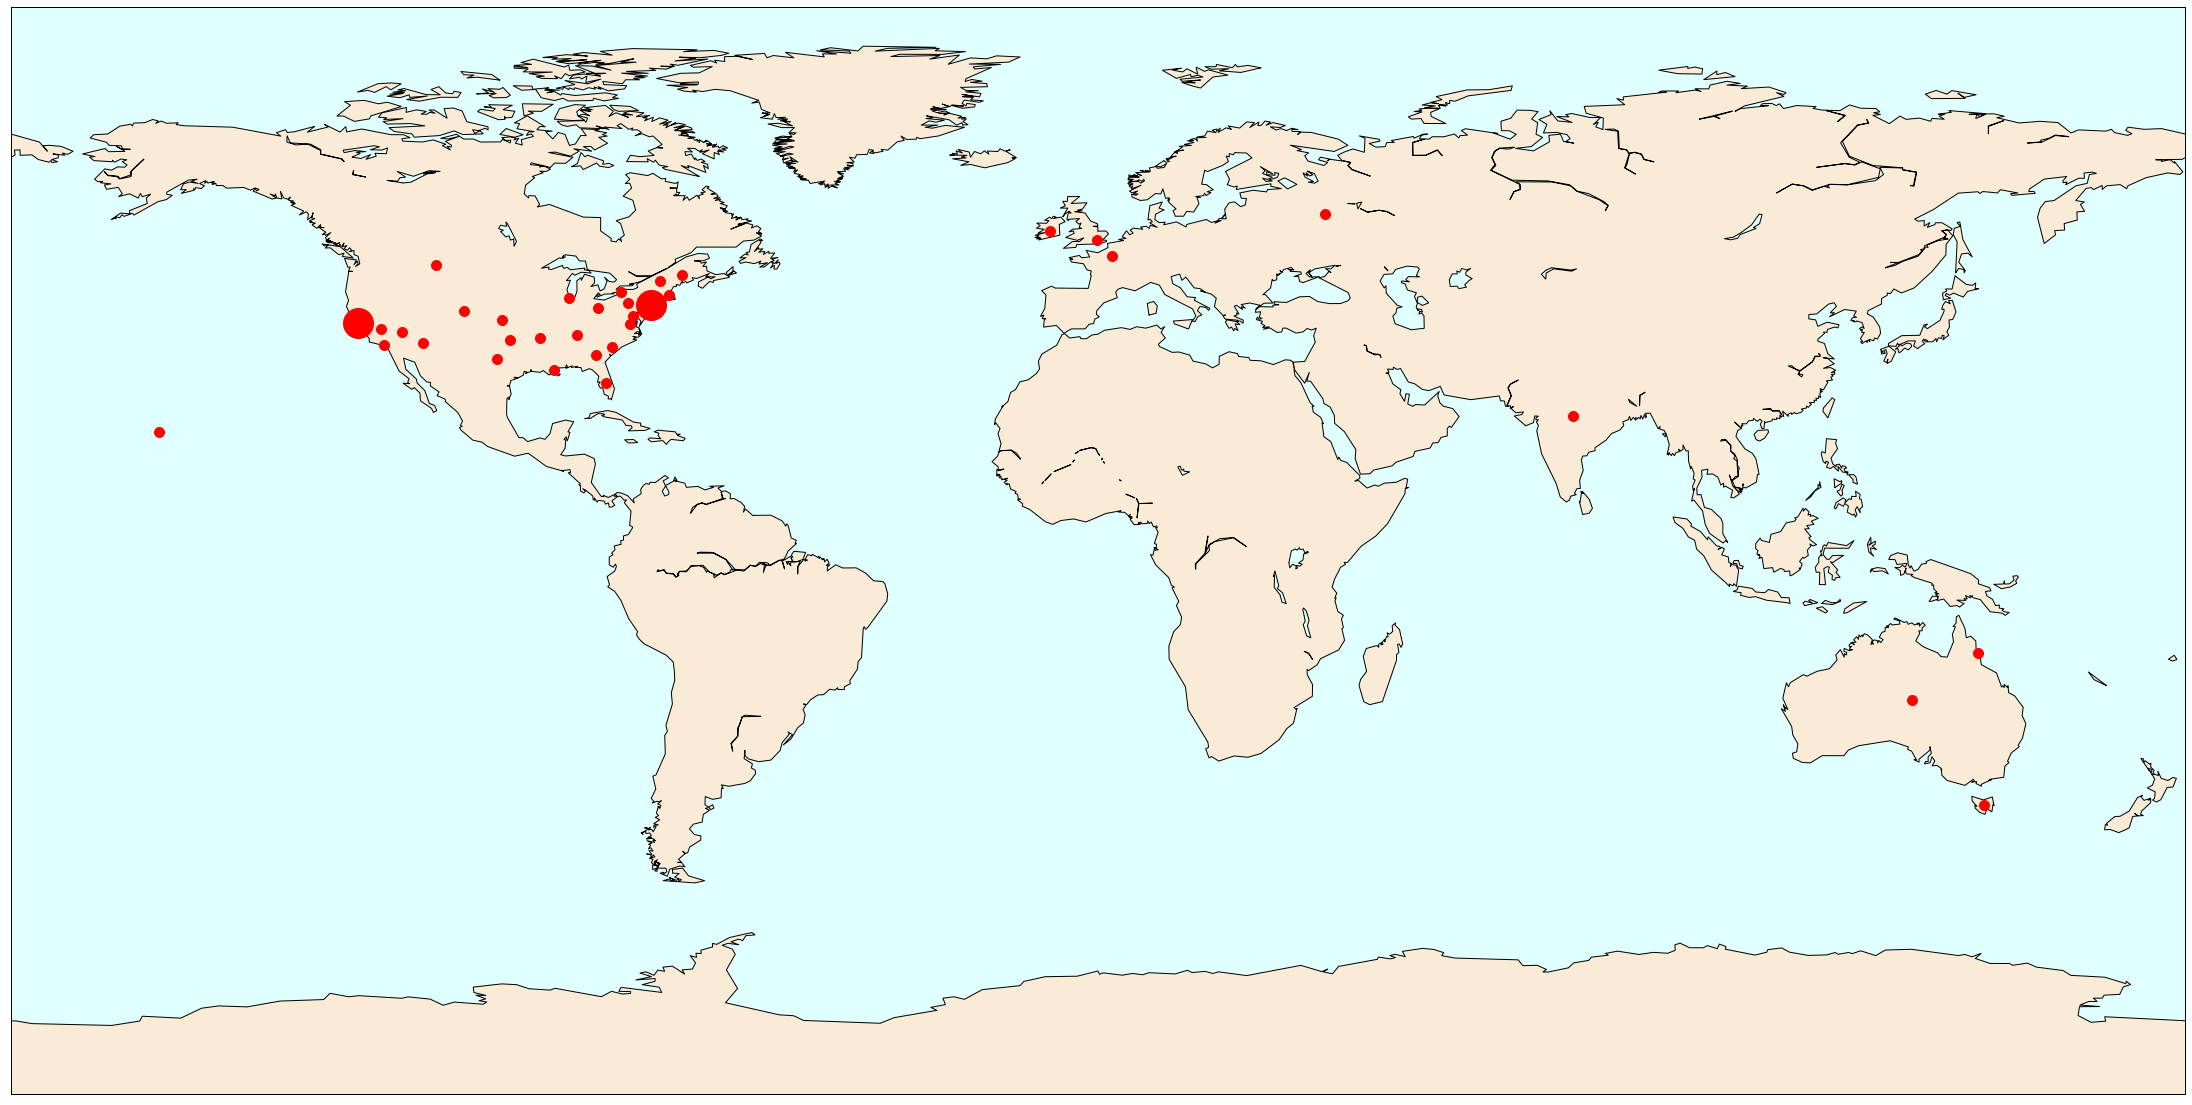

In [ ]:
# World map

plt.figure(figsize=(40,20))
map = Basemap()
map.drawmapboundary(fill_color='#e0ffff')
map.fillcontinents(color='#faebd7',lake_color='#e0ffff')
map.drawcoastlines()

# Get the location of each city with geopy and plot it on the map
geolocator = Nominatim()
scale = 10
for key, value in D.items():
    loc = geolocator.geocode(key)
    x, y = map(loc.longitude, loc.latitude)
    map.plot(x,y,marker='o',color='Red',markersize=int(math.sqrt(value))*scale)
    '''
    if value >= 1:
            if key != 'Boothbay Harbor':
              plt.text(x, y, key, fontsize=16, ha='left',va='center',color='k')
            else:
              plt.text(x, y, "Cabot Cove", fontsize=8,ha='left', va='center',color='k')
    '''
plt.show()

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


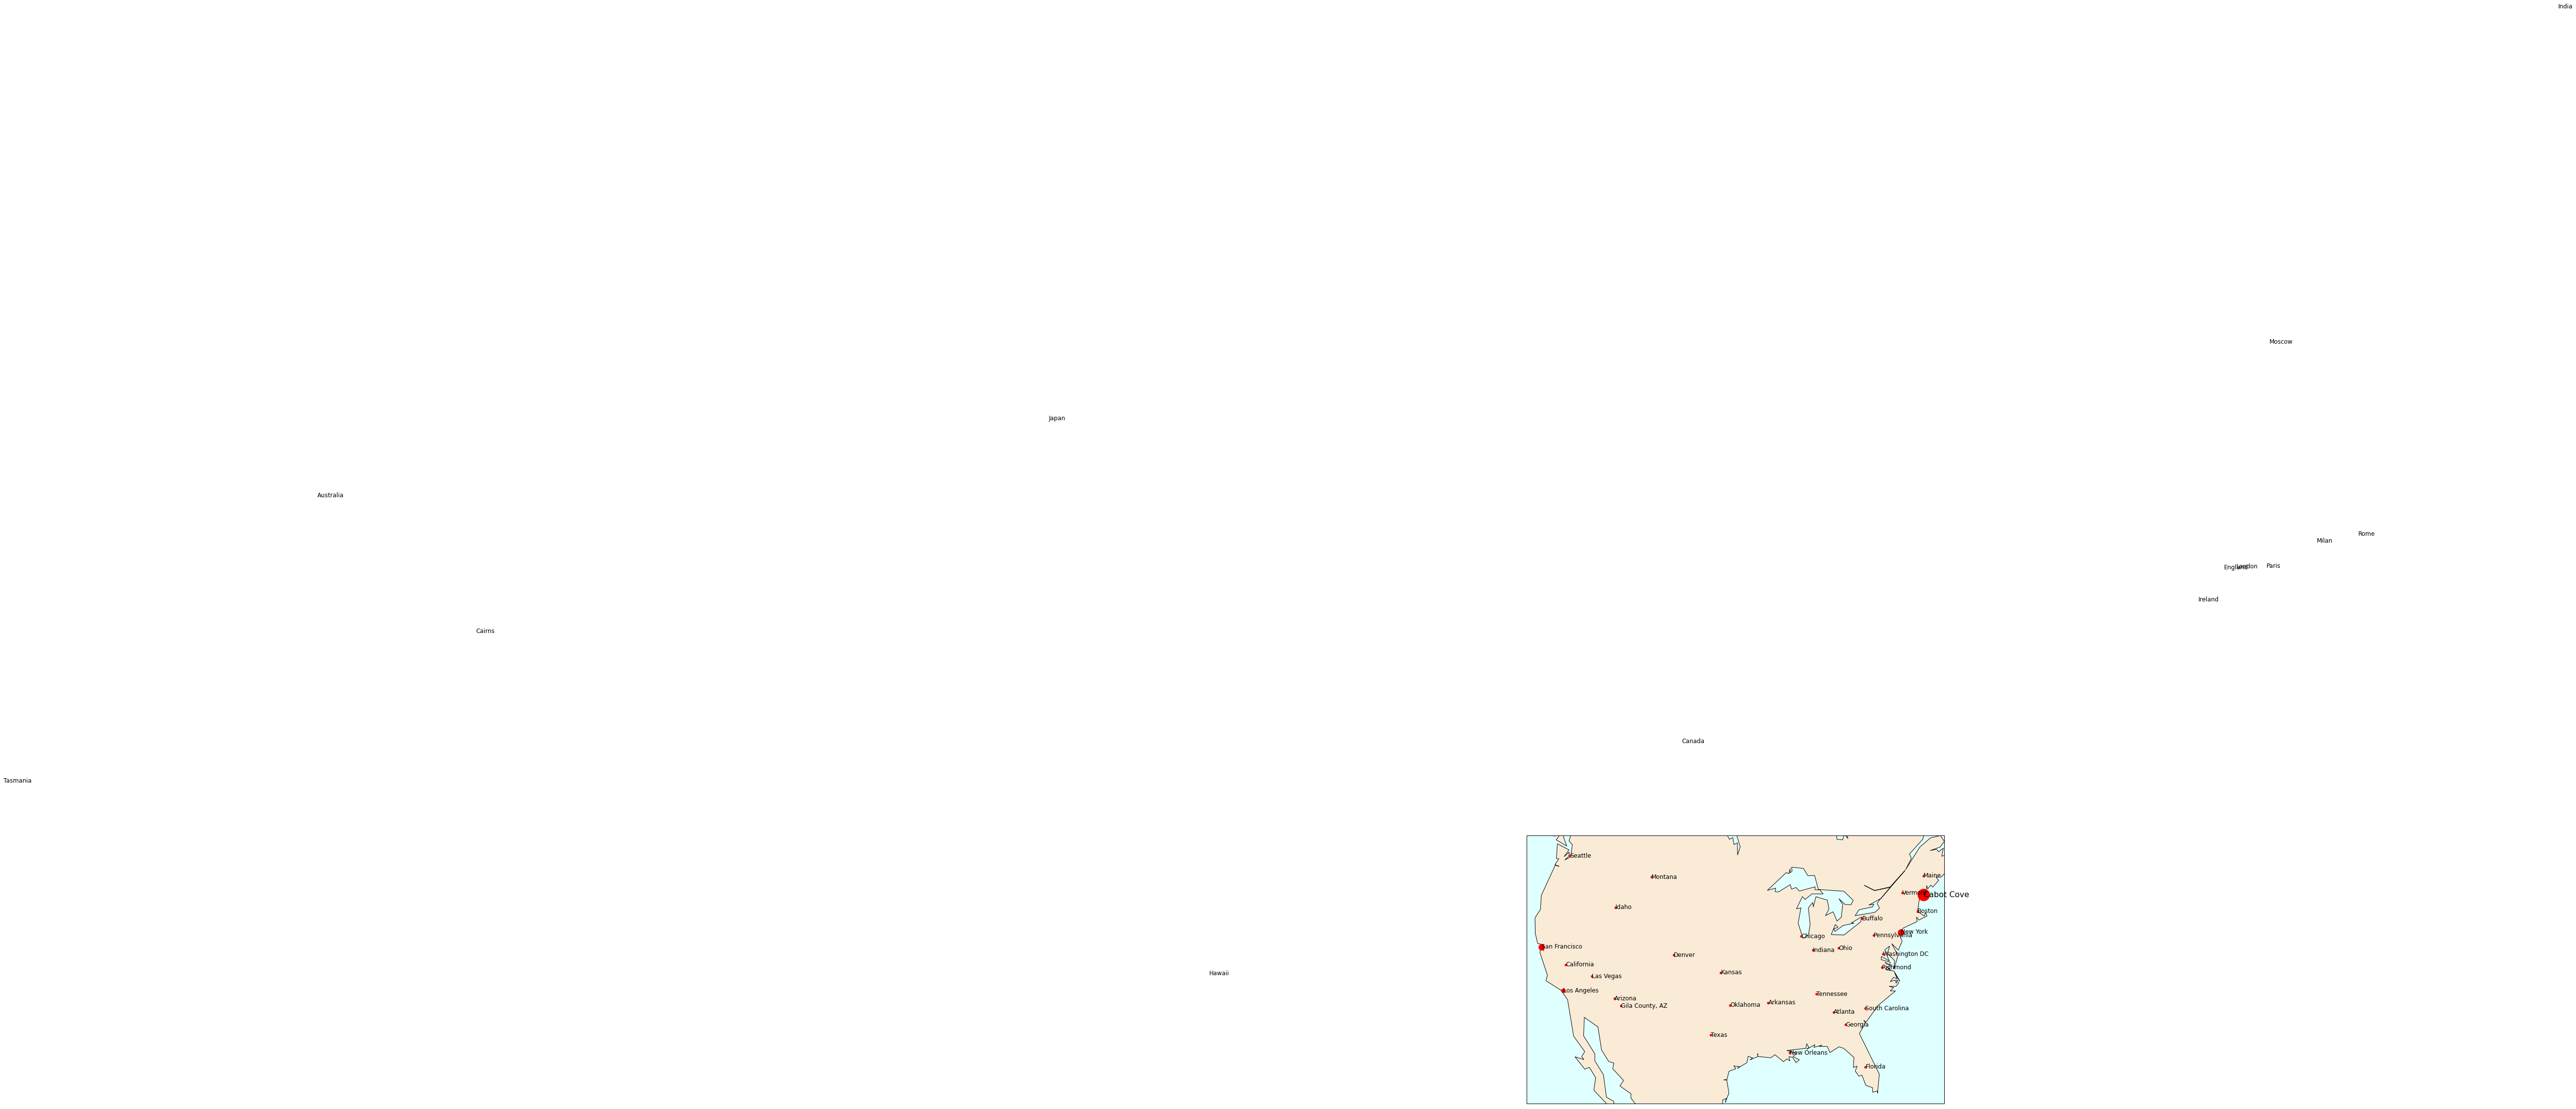

In [ ]:
# USA-specific map

plt.figure(figsize=(20,10))
map2 = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
         projection='lcc',lat_1=32,lat_2=45,lon_0=-95)
map2.drawmapboundary(fill_color='#e0ffff')
map2.fillcontinents(color='#faebd7',lake_color='#e0ffff')
map2.drawcoastlines()

# Get the location of each city with geopy and plot it
geolocator = Nominatim()
scale = 4
for key, value in D.items():
    loc = geolocator.geocode(key)
    x, y = map2(loc.longitude, loc.latitude)
    map2.plot(x,y,marker='o',color='Red',markersize=int(math.sqrt(value))*scale)
    if value >= 1:
        if key != 'Boothbay Harbor':
          plt.text(x, y, key, fontsize=12, ha='left',va='center',color='k')
        else:
          plt.text(x, y, "Cabot Cove", fontsize=16,ha='left', va='center',color='k')
plt.show()

###Bonus: Building a title-plot dictionary 

...perhaps next time it could be useful.

In [ ]:
ep_dict = {}
ep_list = []

num_pag = 1

url = 'https://murdersheblogged1.wordpress.com'

for i in range(1):

    # take in the url
    page = requests.get(url)

    # Create a BeautifulSoup object
    soup = BeautifulSoup(page.text, 'html.parser')

    # Pull all text from the post-content div
    
    ep_title = soup.find_all(class_='post-title')
    ep_description = soup.find_all(class_='post-content')

    # create dictionary with keys = titles and values = descriptions

    ep_dict[str(ep_title)] = str(ep_description)

    num_pag = num_pag + 1

    url = 'https://murdersheblogged1.wordpress.com/page/' + str(num_pag) + '/'
    
    print('I just scraped ' + url)  # the first page is already scraped but no message is printed

# 2. The Short Way 

* Scraping episode tags using ***BeautifulSoup***
* Performing NER (Named Entity Recognition) with ***SpaCy***
* Plotting the results on a real-world map with ***geopy***, ***basemap*** and ***cartopy***


### Scraping and cleaning

In [19]:
# rewrite scraping algorithm for tags 

places_list = []

num_pag = 1 # total = 30

url = 'https://murdersheblogged1.wordpress.com'

for i in range(30):

  page = requests.get(url)

  soup2 = BeautifulSoup(page.text, 'html.parser')

  places = soup2.find_all(class_='posttag')

  places_list.append(places)
  
  num_pag = num_pag + 1

  url = 'https://murdersheblogged1.wordpress.com/page/' + str(num_pag) + '/'

In [20]:
places_list

[[<span class="posttag"><a href="https://murdersheblogged1.wordpress.com/tag/case-closed/" rel="tag">case closed</a>, <a href="https://murdersheblogged1.wordpress.com/tag/repeat-offenders/" rel="tag">repeat offenders</a>, <a href="https://murdersheblogged1.wordpress.com/tag/san-francisco/" rel="tag">San Francisco</a>, <a href="https://murdersheblogged1.wordpress.com/tag/the-end/" rel="tag">the end</a></span>,
  <span class="posttag"><a href="https://murdersheblogged1.wordpress.com/tag/atlanta/" rel="tag">Atlanta</a>, <a href="https://murdersheblogged1.wordpress.com/tag/repeat-offenders/" rel="tag">repeat offenders</a>, <a href="https://murdersheblogged1.wordpress.com/tag/slytherin-queen/" rel="tag">Slytherin Queen</a>, <a href="https://murdersheblogged1.wordpress.com/tag/spy-games/" rel="tag">spy games</a>, <a href="https://murdersheblogged1.wordpress.com/tag/zombies/" rel="tag">zombies</a></span>,
  <span class="posttag"><a href="https://murdersheblogged1.wordpress.com/tag/cabot-cove/

In [22]:
# clean the results

def minimal_cleaning(text):

  new_text = str(text)  
  new_text = re.sub('href=', ' ', new_text)
  new_text = re.sub('https\S+', '', new_text) 
  new_text = re.sub('</a></span>', '', new_text) 
  new_text = re.sub('<a  " rel="tag">', '', new_text) 
  new_text = re.sub('<span class="posttag">', '', new_text)
  new_text = re.sub('</a>', '', new_text) 
 
  return new_text

In [23]:
places_list = minimal_cleaning(places_list)
places_list = str(places_list)

### NER on tags

In [24]:
# perform NER
locations2 = []
doc = spacy_nlp(places_list)
  
for entity in doc.ents:
  if entity.label_ == 'GPE':
    locations2.append(entity.text)

print(locations2)

['San Francisco', 'Atlanta', 'Australia', 'AUSTRALIA', 'Wyoming', 'Los Angeles', 'New York', 'New York', 'Japan', 'New York', 'Minnesota', 'New York', 'Italy', 'Ireland', 'Ireland', 'New Orleans', 'Snakespeare', 'Arizona', 'Colorado', 'New York', 'New York', 'Ireland', 'Jedward', 'prada backpack', 'Paris', 'Hollywood', 'New York', 'drama', 'Italy', 'Cairo', 'mint juleps', 'South Carolina', 'Miami', 'New York', 'California', 'Martinique', 'Reno', 'New York', 'San Francisco', 'Hawaii', 'JB', 'Amsterdam', 'Los Angeles', 'New York', 'Texas', 'New York', 'graffiti', 'New York', 'New York', 'New York', 'New York', 'Canada', 'London', 'New York', 'Ireland', 'Virginia', 'New York', 'New York', 'Hong Kong', 'New York', 'RICHMOND', 'New York', 'Portland', '#', 'New York', 'Los Angeles', 'America', 'Miami', 'New York', 'longggggg', 'Australia', 'New York', 'New York', 'Hegarty', 'San Francisco', 'New Mexico', 'New York', 'Ireland', 'New York', 'thingsnotsaidsincethe90s', 'Milan', 'California', 'M

In [25]:
# standardize
locations2 = [item.lower() for item in locations2]

In [26]:
locations2

['san francisco',
 'atlanta',
 'australia',
 'australia',
 'wyoming',
 'los angeles',
 'new york',
 'new york',
 'japan',
 'new york',
 'minnesota',
 'new york',
 'italy',
 'ireland',
 'ireland',
 'new orleans',
 'snakespeare',
 'arizona',
 'colorado',
 'new york',
 'new york',
 'ireland',
 'jedward',
 'prada backpack',
 'paris',
 'hollywood',
 'new york',
 'drama',
 'italy',
 'cairo',
 'mint juleps',
 'south carolina',
 'miami',
 'new york',
 'california',
 'martinique',
 'reno',
 'new york',
 'san francisco',
 'hawaii',
 'jb',
 'amsterdam',
 'los angeles',
 'new york',
 'texas',
 'new york',
 'graffiti',
 'new york',
 'new york',
 'new york',
 'new york',
 'canada',
 'london',
 'new york',
 'ireland',
 'virginia',
 'new york',
 'new york',
 'hong kong',
 'new york',
 'richmond',
 'new york',
 'portland',
 '#',
 'new york',
 'los angeles',
 'america',
 'miami',
 'new york',
 'longggggg',
 'australia',
 'new york',
 'new york',
 'hegarty',
 'san francisco',
 'new mexico',
 'new york',


In [27]:
# dictionary with places and frequencies

D2 = {}
i = 1

for elem in locations2:
  if elem not in D2.keys():
    D2[elem] = locations2.count(elem)
    
print(D2)

{'san francisco': 12, 'atlanta': 1, 'australia': 3, 'wyoming': 2, 'los angeles': 10, 'new york': 56, 'japan': 1, 'minnesota': 1, 'italy': 2, 'ireland': 5, 'new orleans': 4, 'snakespeare': 1, 'arizona': 3, 'colorado': 1, 'jedward': 1, 'prada backpack': 1, 'paris': 2, 'hollywood': 2, 'drama': 1, 'cairo': 1, 'mint juleps': 1, 'south carolina': 1, 'miami': 2, 'california': 10, 'martinique': 1, 'reno': 1, 'hawaii': 3, 'jb': 17, 'amsterdam': 1, 'texas': 4, 'graffiti': 1, 'canada': 3, 'london': 4, 'virginia': 1, 'hong kong': 1, 'richmond': 1, 'portland': 1, '#': 1, 'america': 1, 'longggggg': 1, 'hegarty': 2, 'new mexico': 2, 'thingsnotsaidsincethe90s': 1, 'milan': 1, 'mexico city': 1, 'butts': 1, 'washington dc': 5, 'las vegas': 1, 'viva tas vegas': 1, 'kentucky': 1, 'missouri': 1, 'n.o.b': 1, 'boston': 6, 'mafia': 1, 'nashville': 1, 'gendry': 1, 'nevada': 1, 'storytime': 1, 'hodor': 1, 'jamaica': 1, 'greece': 1, 'eudora': 1, 'montana': 1, 'new hampshire': 1, 'moscow': 1, 'st louis': 1, 'cabo

In [28]:
# major manual cleaning
del D2['hollywood']
D2['los angeles'] += 2
del D2['snakespeare'] 
del D2['jedward'] 
del D2['prada backpack']
del D2['drama']
del D2['mint juleps']
del D2['jb']
del D2['graffiti']
del D2['#']
del D2['america']
del D2['longggggg']
del D2['hegarty']
del D2['thingsnotsaidsincethe90s']
del D2['butts']
del D2['viva tas vegas']
D2['las vegas'] = 2
del D2['n.o.b']
del D2['mafia']
del D2['gendry']
del D2['storytime']
del D2['hodor']
del D2['eudora']
del D2['cabot cove'] 
del D2['tara']
del D2['tara tiara']
del D2['msw']
del D2['benedryl cummerbund'] 
del D2['amos']
del D2['southwest']
del D2['clue']
del D2['celtic riddle']
del D2['moar george']
del D2['vietnam']
del D2['oil']
del D2['ellsworth buffum']
del D2['ballet']
del D2['broadway']
D2['new york'] = 57
del D2['portland']
D2['portland, Maine'] = 1
#add stand-in for Cabot Cove
D2['boothbay harbor, ME'] = 58

### Mapping with Basemap

In [29]:
# install basemap (if not done before)

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

!pip install pyproj==1.9.6

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math

  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756185 sha256=522101ef6d724d5bc5015673e284c3eb9b50da62ff9c3b35c20ed6aa476c7e41
  Stored in directory: /tmp/pip-ephem-wheel-cache-azbxiuw0/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


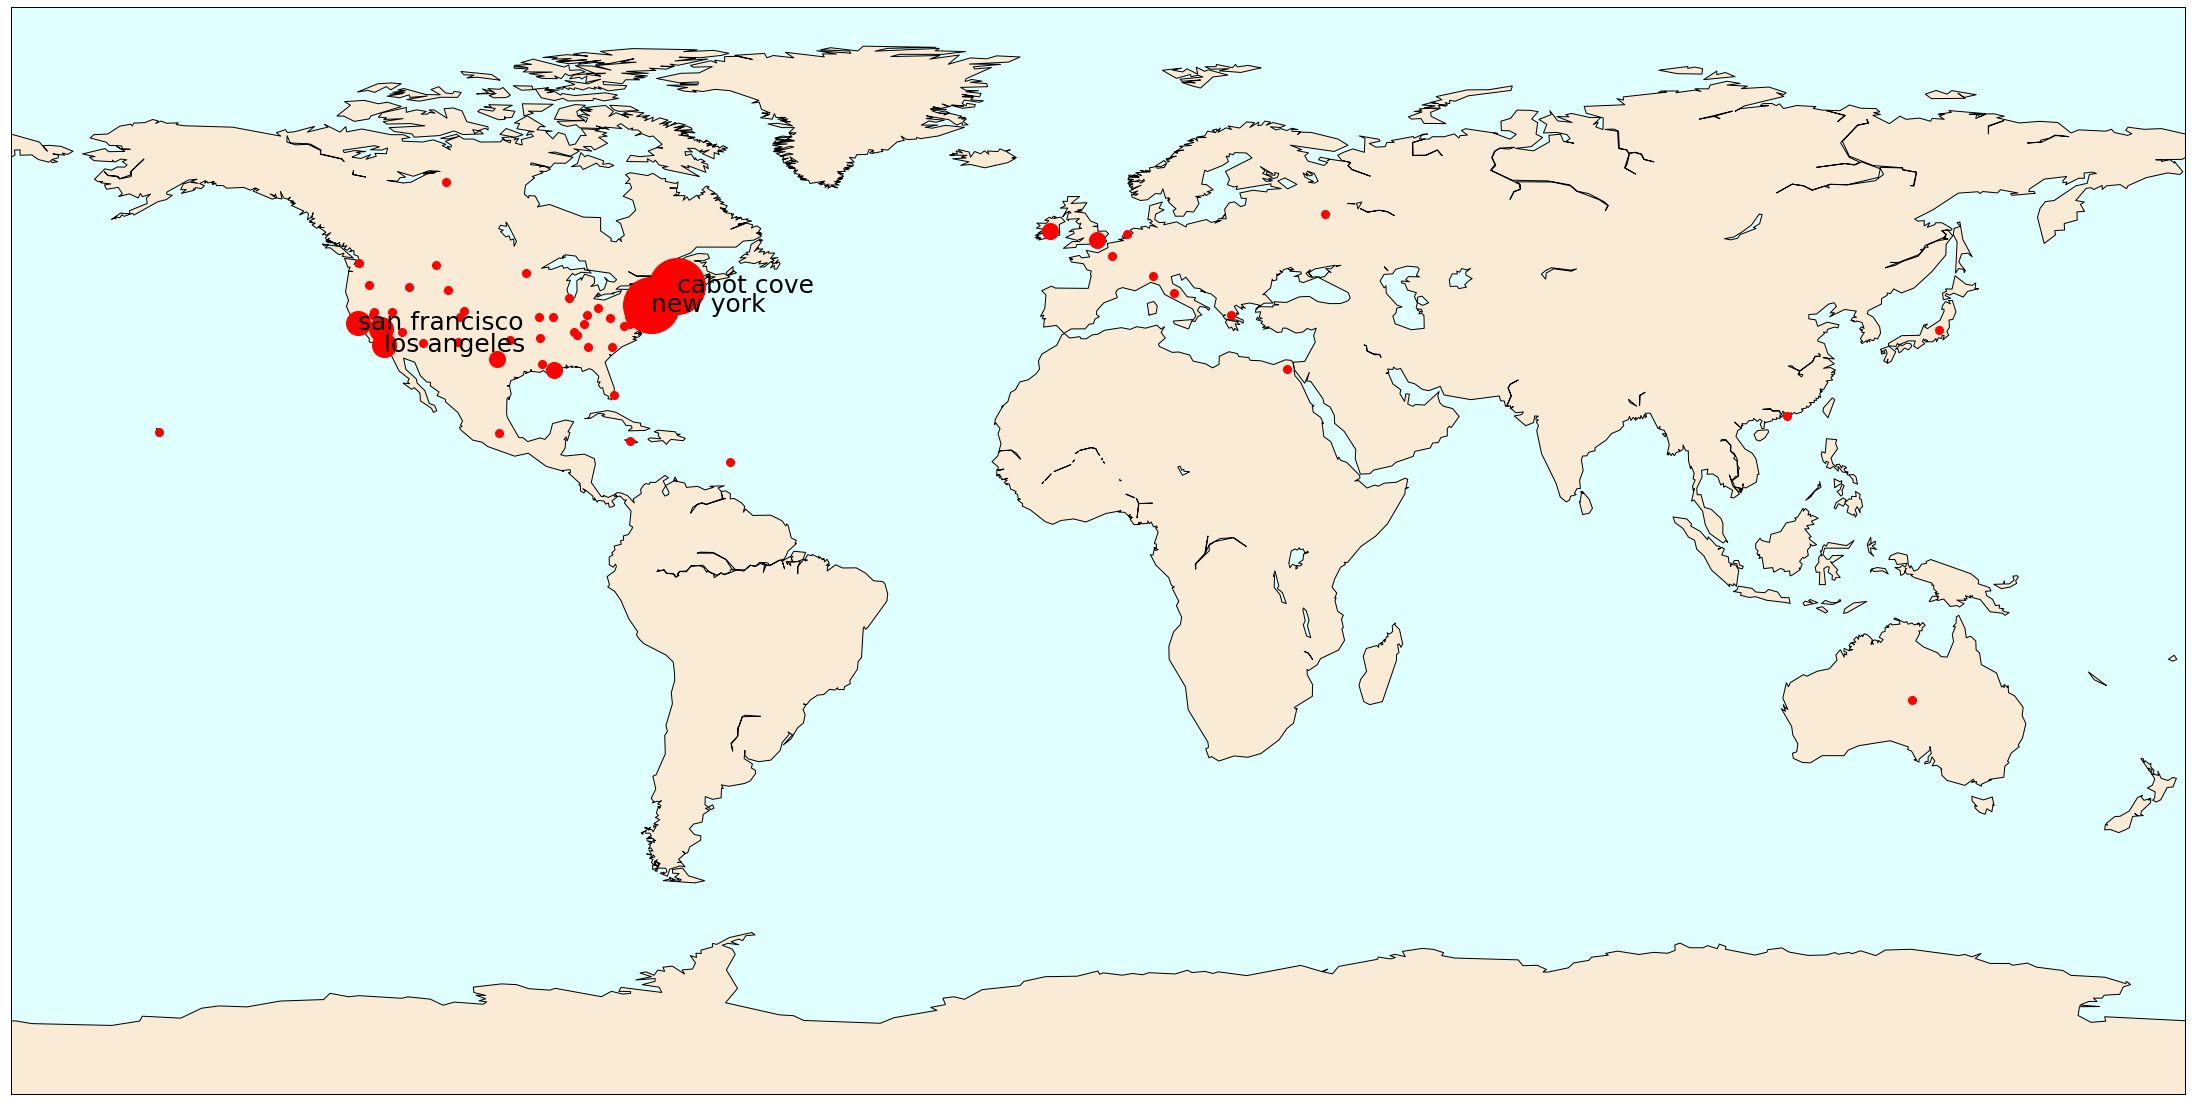

In [30]:
# draw a map

plt.figure(figsize=(40,20))
map = Basemap()
map.drawmapboundary(fill_color='#e0ffff')
map.fillcontinents(color='#faebd7',lake_color='#e0ffff')
map.drawcoastlines()

# Get the location of each city with geopy and plot it
geolocator = Nominatim()
scale = 8
for key, value in D2.items():
    loc = geolocator.geocode(key)
    x, y = map(loc.longitude, loc.latitude)
    map.plot(x,y,marker='o',color='Red',markersize=int(math.sqrt(value))*scale)
    if value >= 12:
            if key != 'boothbay harbor, ME':
              plt.text(x, y, key, fontsize=25, ha='left',va='center',color='k')
            else:
              plt.text(x, y, "cabot cove", fontsize=25,ha='left', va='center',color='k')
    
plt.show()

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


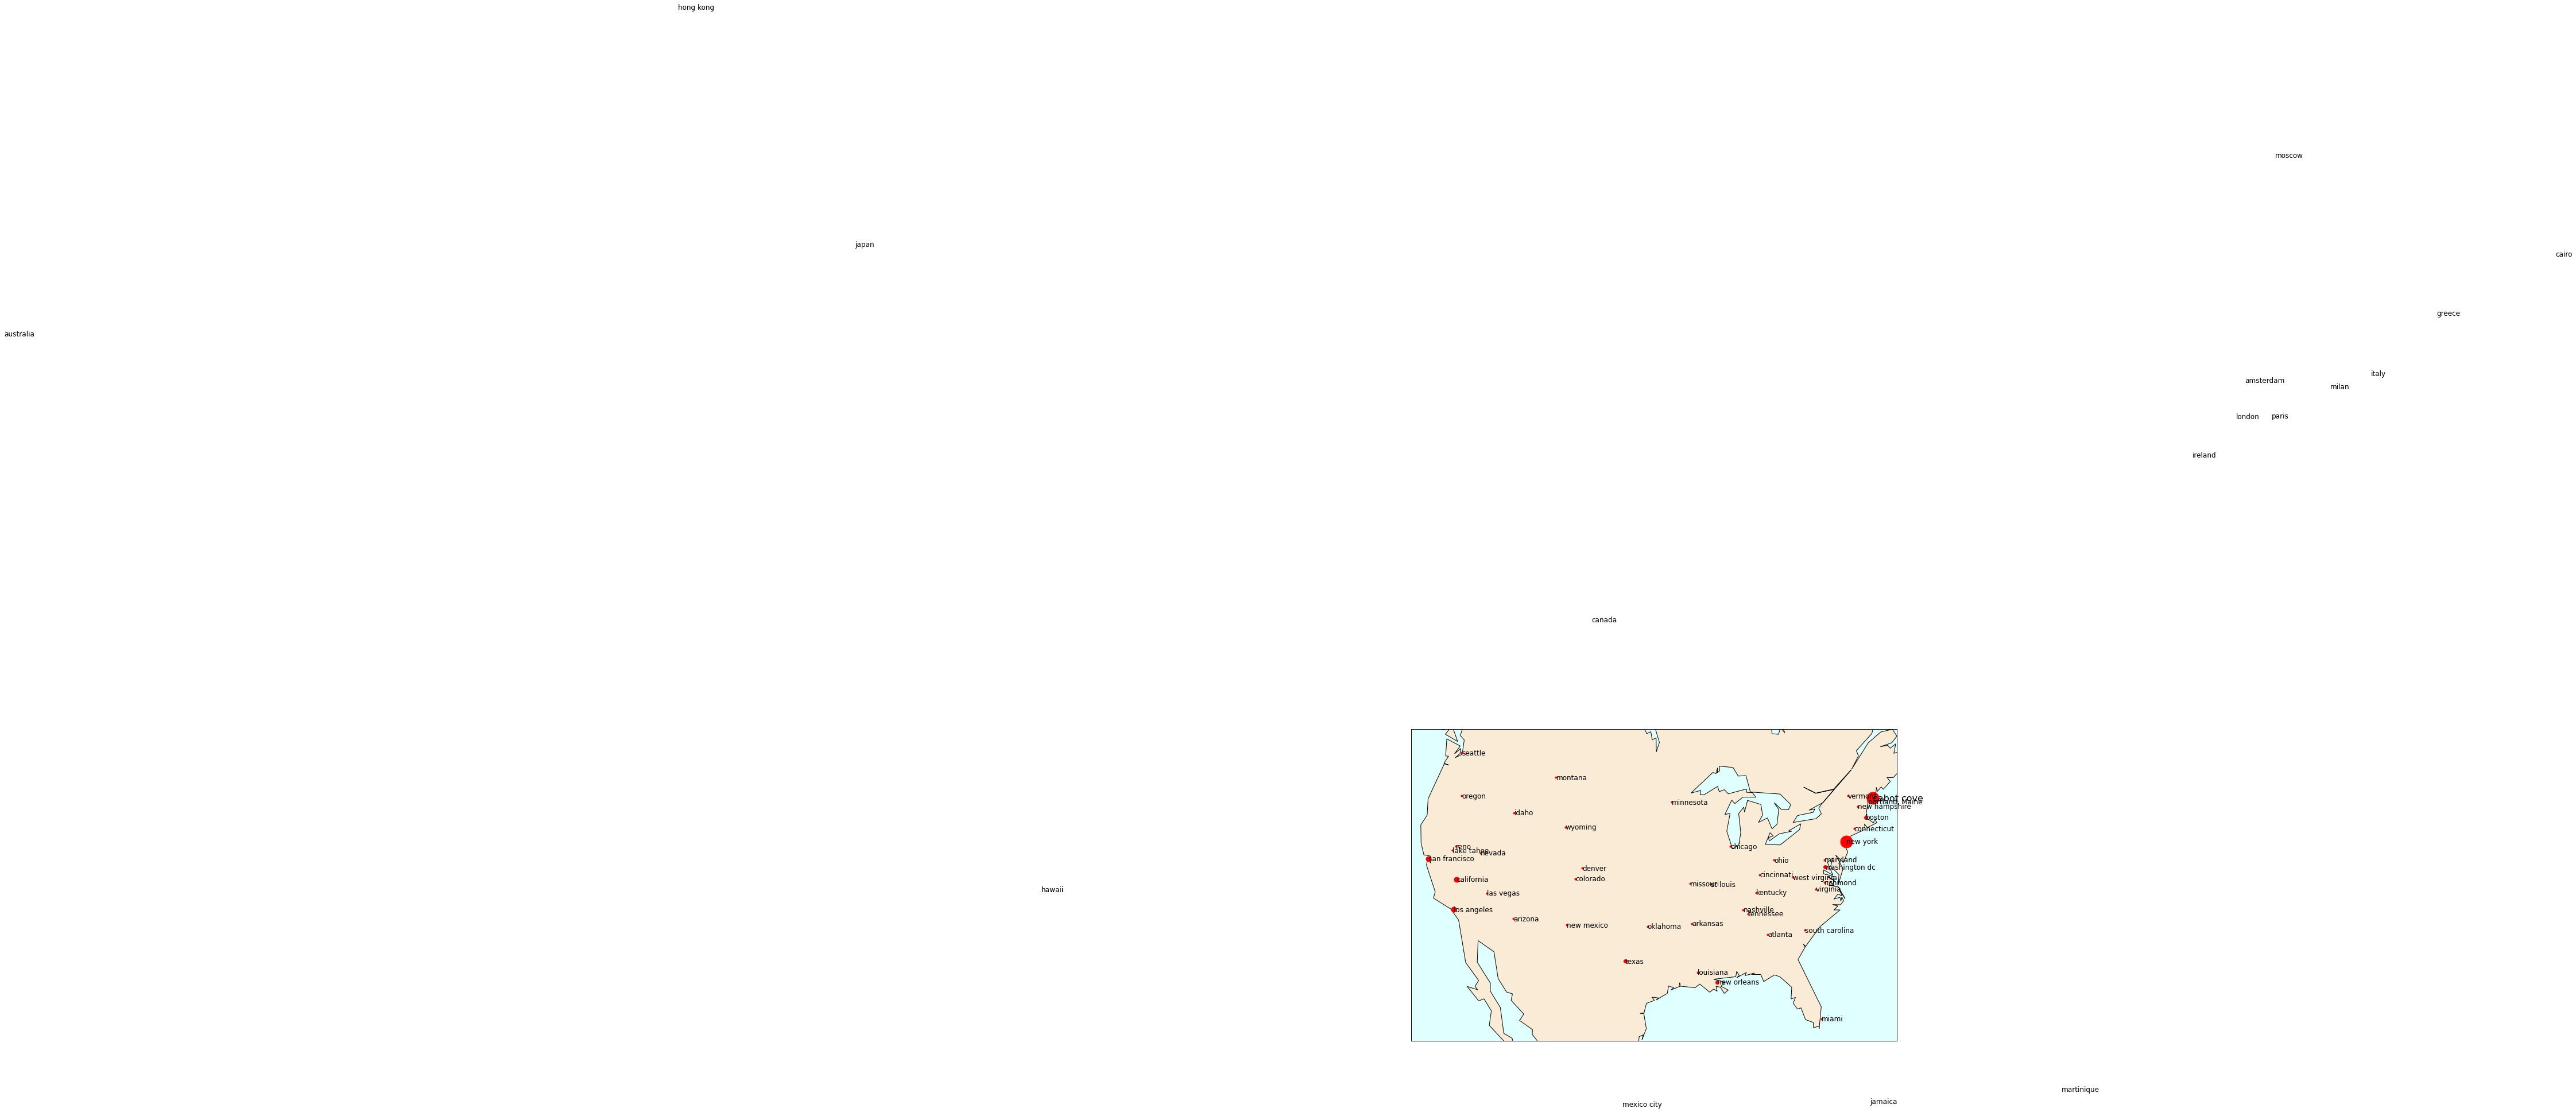

In [ ]:
# USA-specific map

plt.figure(figsize=(20,10))
map2 = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
         projection='lcc',lat_1=32,lat_2=45,lon_0=-95)
map2.drawmapboundary(fill_color='#e0ffff')
map2.fillcontinents(color='#faebd7',lake_color='#e0ffff')
map2.drawcoastlines()

# Get the location of each city with geopy and plot it
geolocator = Nominatim()
scale = 3
for key, value in D2.items():
    loc = geolocator.geocode(key)
    x, y = map2(loc.longitude, loc.latitude)
    map2.plot(x,y,marker='o',color='Red',markersize=int(math.sqrt(value))*scale)
    if value >= 1:
        if key != 'boothbay harbor, ME':
          plt.text(x, y, key, fontsize=12, ha='left',va='center',color='k')
        else:
          plt.text(x, y, "cabot cove", fontsize=16,ha='left', va='center',color='k')
plt.show()

### Mapping with Cartopy

In [31]:
# a main issue of cartopy is that it always crashes on colab when combined with matplotlib
# we'll use the workaround found at: https://github.com/googlecolab/colabtools/issues/833 

!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get update

!apt-get -qq build-dep python3-cartopy
!apt-get -qq remove python-shapely python3-shapely

!pip install --no-binary shapely shapely --force
!pip install --no-binary cartopy cartopy==0.17.0

deb-src http://archive.ubuntu.com/ubuntu/ bionic main restricted
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates main restricted
deb-src http://archive.ubuntu.com/ubuntu/ bionic universe
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates universe
deb-src http://archive.ubuntu.com/ubuntu/ bionic multiverse
deb-src http://archive.ubuntu.com/ubuntu/ bionic-updates multiverse
deb-src http://archive.ubuntu.com/ubuntu/ bionic-backports main restricted universe multiverse
deb-src http://security.ubuntu.com/ubuntu/ bionic-security main restricted
deb-src http://security.ubuntu.com/ubuntu/ bionic-security universe
deb-src http://security.ubuntu.com/ubuntu/ bionic-security multiverse
deb-src https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security 

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


GeocoderServiceError: ignored

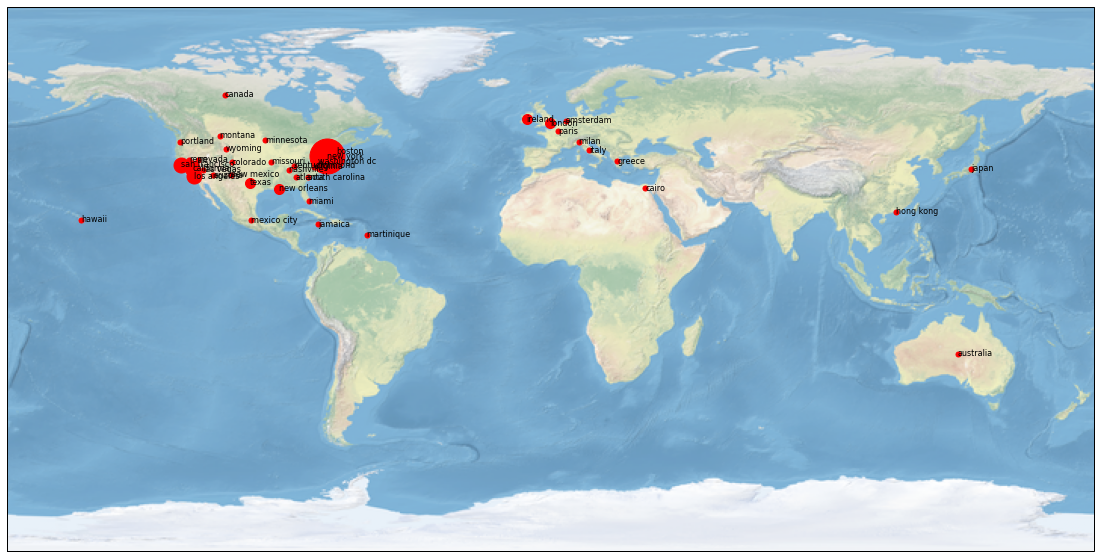

In [ ]:
import cartopy.crs as ccrs

plt.figure(figsize=(20,10))
map = plt.axes(projection=ccrs.PlateCarree())
map.stock_img()

# Get the location of each city with geopy and plot it with cartopy
geolocator = Nominatim()
scale = 5
for key, value in D2.items():
    loc = geolocator.geocode(key)
    x, y = loc.longitude, loc.latitude
    plt.plot( x,y,color='red', linewidth=2, marker='o',markersize=int(math.sqrt(value))*scale)
    if value >= 1:
            if key != 'boothbay harbor, ME':
              plt.text(x, y, key, fontsize=8, ha='left',va='center',color='k')
            else:
              plt.text(x, y, "cabot cove", fontsize=8,ha='left', va='center',color='k')
plt.show()

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


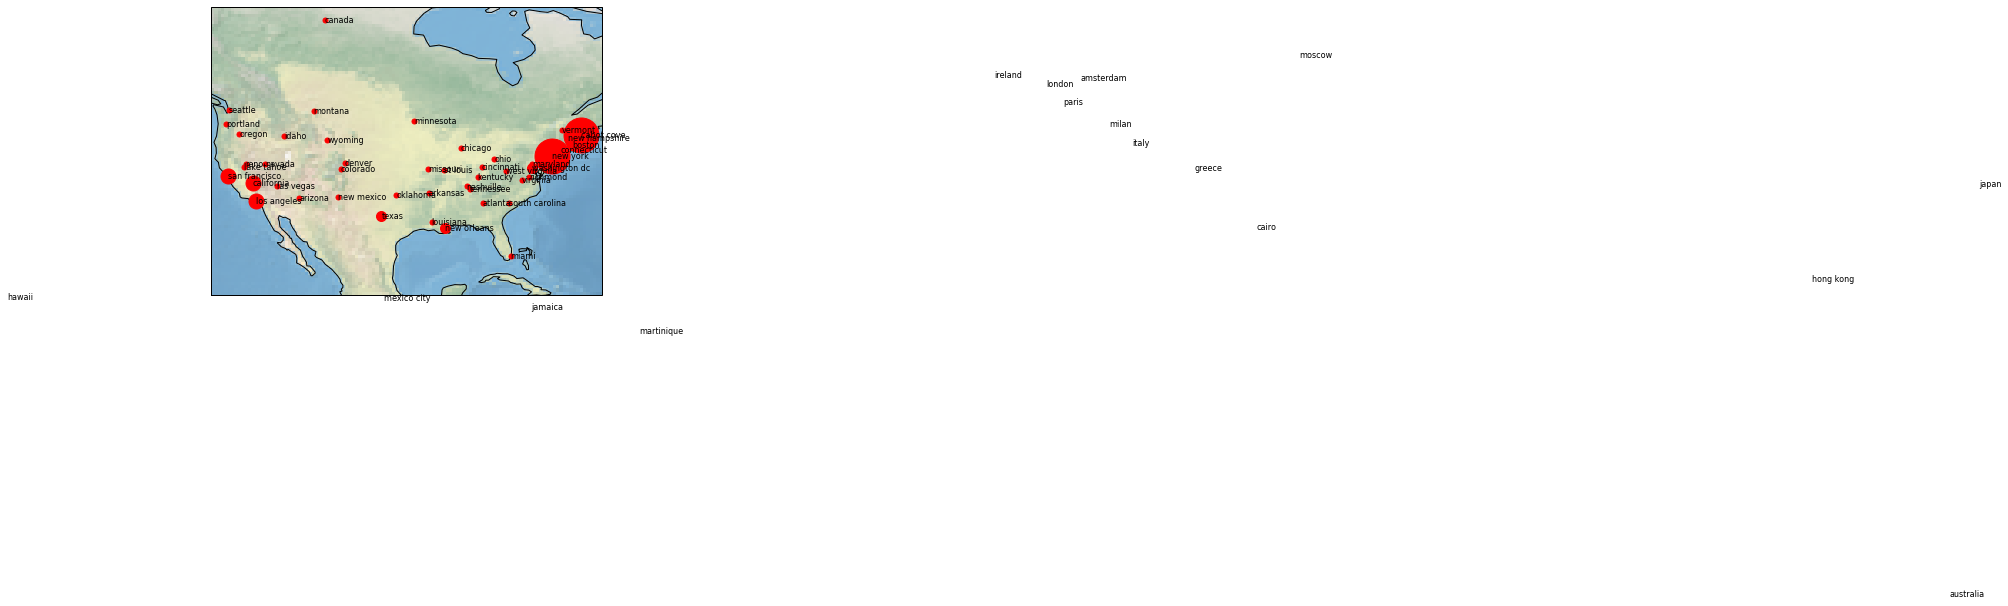

In [ ]:
# draw USA map
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.set_extent([-125, -66.5, 20, 60])

# Get the location of each city with geopy and plot it with cartopy
geolocator = Nominatim()
scale = 5
for key, value in D2.items():
    loc = geolocator.geocode(key)
    x, y = loc.longitude, loc.latitude
    plt.plot( x,y,color='red', linewidth=2, marker='o',markersize=int(math.sqrt(value))*scale)
    if value >= 1:
            if key != 'boothbay harbor, ME':
              plt.text(x, y, key, fontsize=8, ha='left',va='center',color='k')
            else:
              plt.text(x, y, "cabot cove", fontsize=8,ha='left', va='center',color='k')
plt.show()